In [1]:
# importamos los 3 documentos
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
detecciones = pd.read_csv("/content/drive/MyDrive/Archivos_ALeRCE/detections_SNe_v7.0.1.csv")
matches = pd.read_csv("/content/drive/MyDrive/Archivos_ALeRCE/dfcrossmatches_prioritized_v7.0.1.csv")
features_clean = pd.read_parquet("/content/drive/MyDrive/Archivos_ALeRCE/features_cleaned.parquet", engine="pyarrow")

In [3]:
# fusión de documentos por oid
datos_fusionados = features_clean.merge(
    matches[['oid', 'classALeRCE']],
    on='oid', how='left'
)

# filtrar supernovas, incluyendo SN y SLSN
datos_supernovas = datos_fusionados[
    (datos_fusionados['classALeRCE'].str.startswith('SN', na=False)) |
    (datos_fusionados['classALeRCE'] == 'SLSN')
].copy()

In [4]:
# importamos la librería para usar balanced random forest
!pip install imbalanced-learn
from imblearn.ensemble import BalancedRandomForestClassifier

In [5]:
# importamos librerias para dividir la base de datos
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

In [6]:
X = datos_supernovas.drop(columns=['oid', 'classALeRCE'])
Y = datos_supernovas['classALeRCE']

Y = Y.replace({'SNIIn': 'SNII', 'SNIIb': 'SNII'})

X = X.fillna(-999) ####

print(f"Dimensiones de X (Características): {X.shape}")
print(f"Dimensiones de Y (Etiquetas): {Y.shape}")
print("Clases únicas en Y:", Y.unique())

Dimensiones de X (Características): (1823, 178)
Dimensiones de Y (Etiquetas): (1823,)
Clases únicas en Y: ['SNIa' 'SNIbc' 'SNII' 'SLSN']


In [39]:
# dividimos en 80% (Entrenamiento) y 20% (Test)
X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.2, # Ahora es 20% para Test
    random_state=42,
    stratify=Y
)

# mostramos dimensiones
print("\n--- Distribución de los Conjuntos ---")
print(f"Entrenamiento (80%): X={X_train.shape}, Y={Y_train.shape}")
print(f"Test (20%): X={X_test.shape}, Y={Y_test.shape}")


--- Distribución de los Conjuntos ---
Entrenamiento (80%): X=(1458, 178), Y=(1458,)
Test (20%): X=(365, 178), Y=(365,)


In [40]:
# entrenamiento del Balanced Random Forest
brf = BalancedRandomForestClassifier(
    n_estimators=500,
    sampling_strategy='auto',
    random_state=42,
    n_jobs=-1
)

print("\nEntrenando Balanced Random Forest con imputación -999...")
brf.fit(X_train, Y_train)
print("Entrenamiento completado.")

print("\nEntrenando Balanced Random Forest con imputación -999...")
brf.fit(X_train, Y_train)
print("Entrenamiento completado.")

# Evaluación inicial
Y_pred_val = brf.predict(X_test)
print("\n--- Métricas en el Conjunto de Validación ---")
print(classification_report(Y_test, Y_pred_val))


Entrenando Balanced Random Forest con imputación -999...
Entrenamiento completado.

Entrenando Balanced Random Forest con imputación -999...
Entrenamiento completado.

--- Métricas en el Conjunto de Validación ---
              precision    recall  f1-score   support

        SLSN       0.21      0.80      0.33         5
        SNII       0.71      0.60      0.65        68
        SNIa       0.92      0.76      0.83       273
       SNIbc       0.14      0.47      0.22        19

    accuracy                           0.72       365
   macro avg       0.50      0.66      0.51       365
weighted avg       0.83      0.72      0.76       365



In [41]:
# importamos librerías para mostrar las matrices de confusión
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [42]:
def plot_normalized_confusion_matrix(Y_true, Y_pred, title, ax):
    """
    Genera y plotea la matriz de confusión normalizada.

    Y_true: Etiquetas verdaderas.
    Y_pred: Predicciones del modelo.
    title: Título para el gráfico.
    ax: Objeto Axes de Matplotlib para dibujar.
    """
    # Calcular la matriz de confusión
    cm = confusion_matrix(Y_true, Y_pred)

    # Normalizar la matriz (por fila, para obtener el Recall)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Obtener las etiquetas de las clases
    class_labels = np.unique(Y_true)

    # Crear el mapa de calor (heatmap)
    sns.heatmap(
        cm_normalized,
        annot=True, # Mostrar los valores
        fmt=".2f", # Formato de 2 decimales
        cmap="Blues", # Mapa de color
        cbar=True, # Mostrar barra de color
        xticklabels=class_labels, # Etiquetas del eje X (Predichas)
        yticklabels=class_labels, # Etiquetas del eje Y (Verdaderas)
        ax=ax
    )

    # Configuración de títulos y etiquetas
    ax.set_title(title)
    ax.set_ylabel('Etiqueta Verdadera')
    ax.set_xlabel('Etiqueta Predicha')

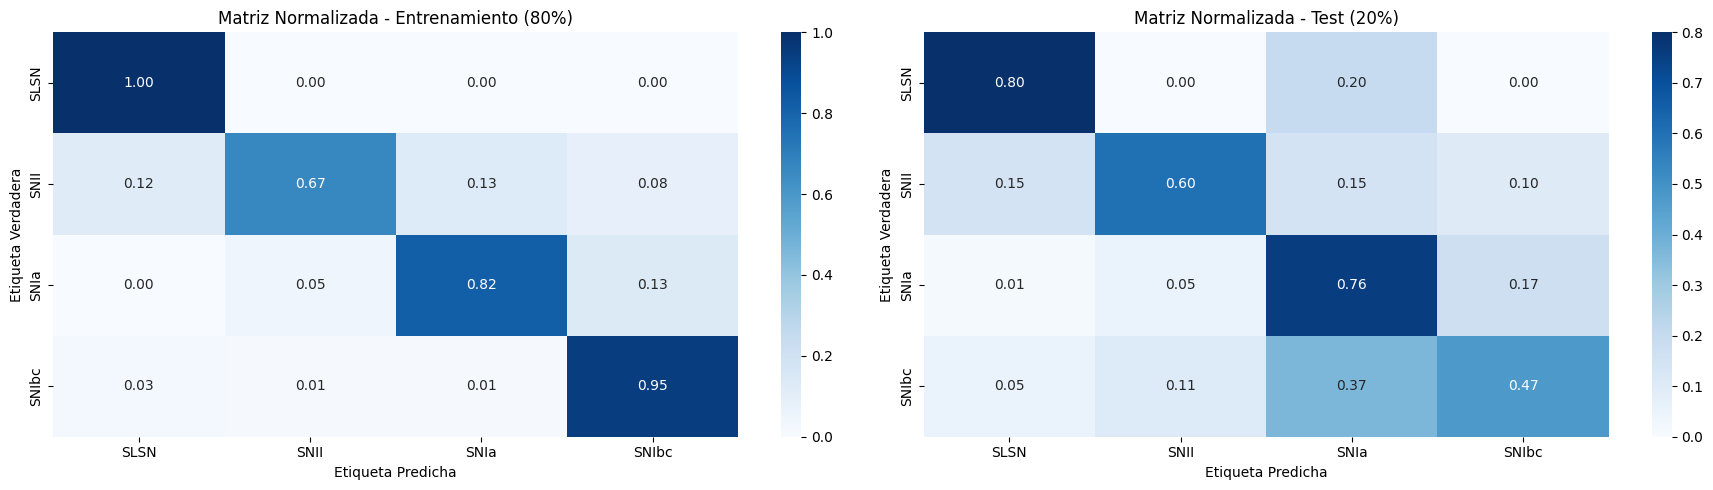

In [43]:
# 1. Obtener Predicciones

# Predicciones de Entrenamiento
Y_pred_train = brf.predict(X_train)

# Predicciones de Test
Y_pred_test = brf.predict(X_test)


# 2. Crear la Figura y los Subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 5)) # 1 fila, 2 columnas

# 3. Plotear cada Matriz
# Matriz de Entrenamiento
plot_normalized_confusion_matrix(
    Y_train,
    Y_pred_train,
    title='Matriz Normalizada - Entrenamiento (80%)',
    ax=axes[0]
)

# Matriz de Test
plot_normalized_confusion_matrix(
    Y_test,
    Y_pred_test,
    title='Matriz Normalizada - Test (20%)',
    ax=axes[1]
)

# Ajustar el layout y mostrar
plt.tight_layout()
plt.show()


ANÁLISIS DE FEATURE IMPORTANCE

Top 20 Features Más Importantes:
------------------------------------------------------------
             feature  importance
            SPM_t0_g    0.028226
         SPM_gamma_r    0.026840
         g-r_max_g_r    0.021801
            SPM_t0_r    0.020165
      SPM_tau_rise_r    0.018889
       LinearTrend_r    0.018293
         first_mag_r    0.018142
        g-r_mean_g_r    0.015885
        MHPS_ratio_g    0.014473
     delta_mjd_fid_g    0.013940
dmag_first_det_fid_g    0.012906
         first_mag_g    0.012621
          SPM_beta_r    0.012318
            sgscore1    0.011903
      SPM_tau_rise_g    0.011712
      SPM_tau_fall_r    0.011588
     delta_mjd_fid_r    0.010870
         MHPS_high_g    0.010081
   AndersonDarling_r    0.009749
          MHPS_low_g    0.009593

------------------------------------------------------------
Total de features: 178
Importancia total (suma): 1.0000
Importancia promedio: 0.0056
Importancia máxima: 0.0282


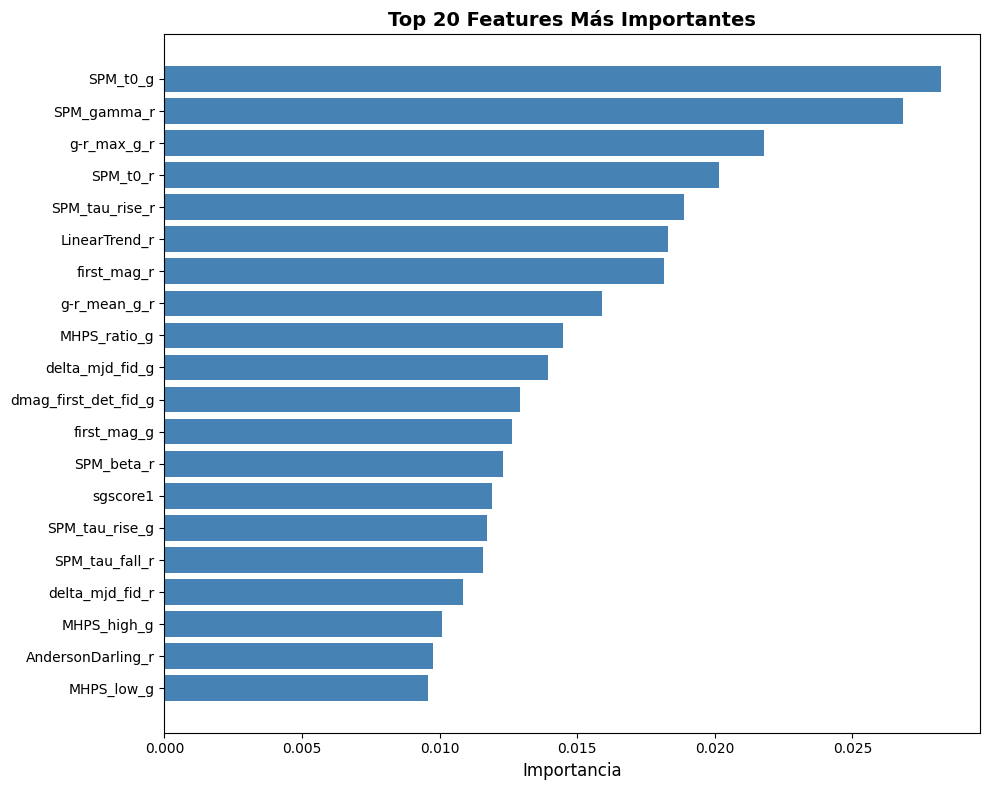

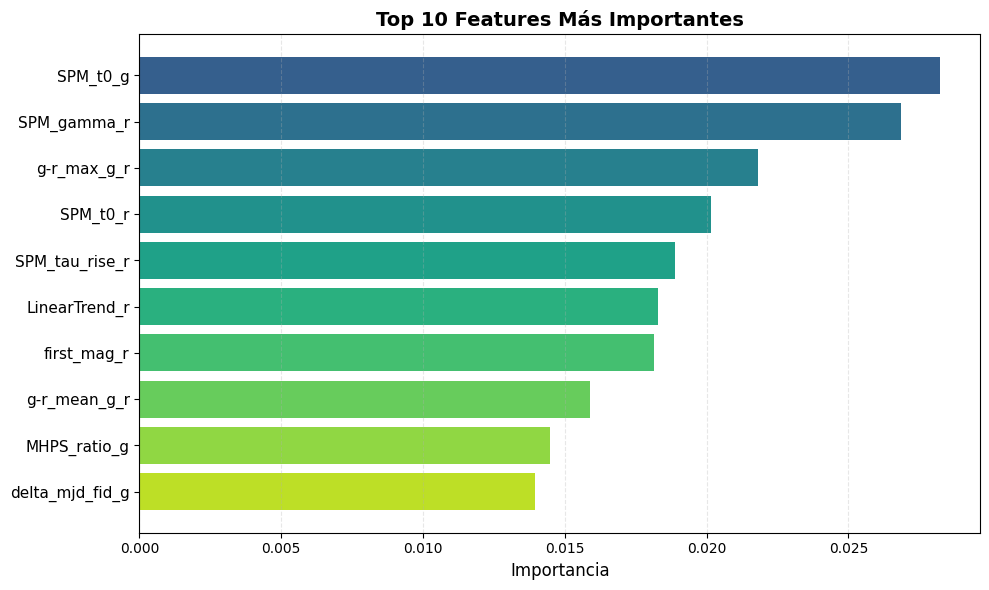

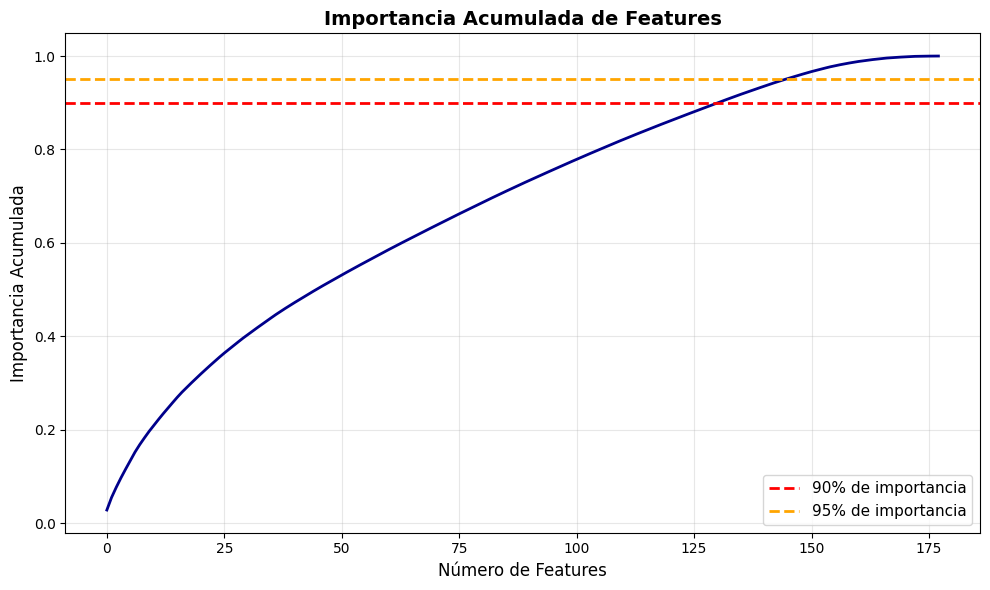


ANÁLISIS DE IMPORTANCIA ACUMULADA
Features para 90% de importancia: 132 de 178
Features para 95% de importancia: 146 de 178
Porcentaje de features para 90%: 74.2%
Porcentaje de features para 95%: 82.0%

ANÁLISIS DE FEATURES SPM
Total SPM features: 14
SPM features en top 10: 4
SPM features en top 20: 7
Importancia total SPM: 0.1724
Importancia promedio SPM: 0.0123


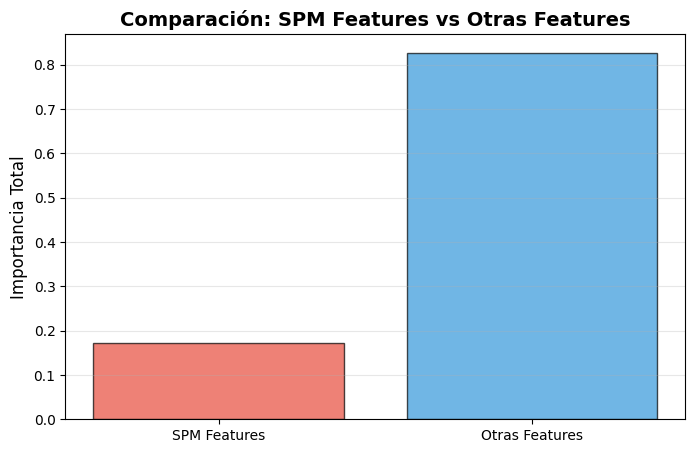

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# ===== BLOQUE: FEATURE IMPORTANCE =====
print("\n" + "="*60)
print("ANÁLISIS DE FEATURE IMPORTANCE")
print("="*60)

# 1. Obtener importancia de features del modelo final
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': brf.feature_importances_
}).sort_values('importance', ascending=False)

# 2. Mostrar top 20 features
print("\nTop 20 Features Más Importantes:")
print("-" * 60)
print(feature_importance.head(20).to_string(index=False))

# 3. Estadísticas
print("\n" + "-" * 60)
print(f"Total de features: {len(feature_importance)}")
print(f"Importancia total (suma): {feature_importance['importance'].sum():.4f}")
print(f"Importancia promedio: {feature_importance['importance'].mean():.4f}")
print(f"Importancia máxima: {feature_importance['importance'].max():.4f}")

# 4. Visualización 1: Top 20 features
plt.figure(figsize=(10, 8))
top_20 = feature_importance.head(20)
plt.barh(range(len(top_20)), top_20['importance'], color='steelblue')
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Importancia', fontsize=12)
plt.title('Top 20 Features Más Importantes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 5. Visualización 2: Top 10 features
plt.figure(figsize=(10, 6))
top_10 = feature_importance.head(10)
colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_10)))
plt.barh(range(len(top_10)), top_10['importance'], color=colors)
plt.yticks(range(len(top_10)), top_10['feature'], fontsize=11)
plt.xlabel('Importancia', fontsize=12)
plt.title('Top 10 Features Más Importantes', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 6. Visualización 3: Importancia acumulada
plt.figure(figsize=(10, 6))
cumulative_importance = np.cumsum(feature_importance['importance'])
plt.plot(range(len(cumulative_importance)), cumulative_importance,
         linewidth=2, color='darkblue')
plt.axhline(y=0.90, color='red', linestyle='--',
            label='90% de importancia', linewidth=2)
plt.axhline(y=0.95, color='orange', linestyle='--',
            label='95% de importancia', linewidth=2)
plt.xlabel('Número de Features', fontsize=12)
plt.ylabel('Importancia Acumulada', fontsize=12)
plt.title('Importancia Acumulada de Features', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 7. ¿Cuántas features necesitas para el 90% y 95%?
idx_90 = np.where(cumulative_importance >= 0.90)[0][0] + 1
idx_95 = np.where(cumulative_importance >= 0.95)[0][0] + 1

print("\n" + "="*60)
print("ANÁLISIS DE IMPORTANCIA ACUMULADA")
print("="*60)
print(f"Features para 90% de importancia: {idx_90} de {len(feature_importance)}")
print(f"Features para 95% de importancia: {idx_95} de {len(feature_importance)}")
print(f"Porcentaje de features para 90%: {100*idx_90/len(feature_importance):.1f}%")
print(f"Porcentaje de features para 95%: {100*idx_95/len(feature_importance):.1f}%")

# 8. Visualización 4: Comparación de features SPM vs otras
spm_features = feature_importance[feature_importance['feature'].str.contains('SPM', case=False)]
other_features = feature_importance[~feature_importance['feature'].str.contains('SPM', case=False)]

if len(spm_features) > 0:
    print("\n" + "="*60)
    print("ANÁLISIS DE FEATURES SPM")
    print("="*60)
    print(f"Total SPM features: {len(spm_features)}")
    print(f"SPM features en top 10: {len([f for f in top_10['feature'] if 'SPM' in f.upper()])}")
    print(f"SPM features en top 20: {len([f for f in top_20['feature'] if 'SPM' in f.upper()])}")
    print(f"Importancia total SPM: {spm_features['importance'].sum():.4f}")
    print(f"Importancia promedio SPM: {spm_features['importance'].mean():.4f}")

    # Plot comparación
    fig, ax = plt.subplots(figsize=(8, 5))
    categories = ['SPM Features', 'Otras Features']
    importances = [spm_features['importance'].sum(), other_features['importance'].sum()]
    colors_cat = ['#e74c3c', '#3498db']

    bars = ax.bar(categories, importances, color=colors_cat, alpha=0.7, edgecolor='black')
    ax.set_ylabel('Importancia Total', fontsize=12)
    ax.set_title('Comparación: SPM Features vs Otras Features',
                 fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)

    # Agregar valores


In [45]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# PASO 1: DEFINIR CUÁNTAS FEATURES USAR
# ============================================================

# Cambiar este valor según cuántas features quieras usar
N = 30  # Puedes probar con 20, 30, 50, 100, etc.

# Seleccionar las top N features
top_n_features = feature_importance.head(N)['feature'].tolist()

print(f"\n{'='*60}")
print(f"USANDO LAS TOP {N} FEATURES")
print(f"{'='*60}")
print("\nFeatures seleccionadas:")
for i, feat in enumerate(top_n_features, 1):
    imp = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    print(f"{i:2d}. {feat:30s} (importancia: {imp:.4f})")

# ============================================================
# PASO 2: CREAR DATASET REDUCIDO
# ============================================================

# Seleccionar solo las columnas de top N features
X_reduced = X[top_n_features].copy()
Y_reduced = Y.copy()

# Imputar NaN con -999 (como el paper)
X_reduced = X_reduced.fillna(-999)

print(f"\n{'='*60}")
print("INFORMACIÓN DEL DATASET REDUCIDO")
print(f"{'='*60}")
print(f"Total de muestras: {len(X_reduced)}")
print(f"Total de features: {len(top_n_features)}")
print(f"Ratio muestras/features: {len(X_reduced)/len(top_n_features):.1f}")
print(f"\nDistribución de clases:")
print(Y_reduced.value_counts())

# ============================================================
# PASO 3: DIVIDIR EN 80/20
# ============================================================

# Dividir en 80% (entrenamiento) y 20% (prueba)
X_train, X_test, Y_train, Y_test = train_test_split(
    X_reduced, Y_reduced,
    test_size=0.2, # Ahora es 20% para Test
    random_state=42,
    stratify=Y_reduced
)

print(f"\n--- Distribución de los Conjuntos ---")
print(f"Entrenamiento (80%): X={X_train.shape}, Y={Y_train.shape}")
print(f"Test (20%): X={X_test.shape}, Y={Y_test.shape}")

# ============================================================
# PASO 4: ENTRENAR EL MODELO
# ============================================================

print(f"\nEntrenando Balanced Random Forest con top {N} features...")
brf_reduced = BalancedRandomForestClassifier(
    n_estimators=500,
    sampling_strategy='auto',
    random_state=42,
    n_jobs=-1
)

brf_reduced.fit(X_train, Y_train)
print("Entrenamiento completado.")

# ============================================================
# PASO 6: EVALUAR EN TEST
# ============================================================

Y_pred_test = brf_reduced.predict(X_test)

print(f"\n--- Métricas en el Conjunto de Test ---")
print(classification_report(Y_test, Y_pred_test))




USANDO LAS TOP 30 FEATURES

Features seleccionadas:
 1. SPM_t0_g                       (importancia: 0.0282)
 2. SPM_gamma_r                    (importancia: 0.0268)
 3. g-r_max_g_r                    (importancia: 0.0218)
 4. SPM_t0_r                       (importancia: 0.0202)
 5. SPM_tau_rise_r                 (importancia: 0.0189)
 6. LinearTrend_r                  (importancia: 0.0183)
 7. first_mag_r                    (importancia: 0.0181)
 8. g-r_mean_g_r                   (importancia: 0.0159)
 9. MHPS_ratio_g                   (importancia: 0.0145)
10. delta_mjd_fid_g                (importancia: 0.0139)
11. dmag_first_det_fid_g           (importancia: 0.0129)
12. first_mag_g                    (importancia: 0.0126)
13. SPM_beta_r                     (importancia: 0.0123)
14. sgscore1                       (importancia: 0.0119)
15. SPM_tau_rise_g                 (importancia: 0.0117)
16. SPM_tau_fall_r                 (importancia: 0.0116)
17. delta_mjd_fid_r                

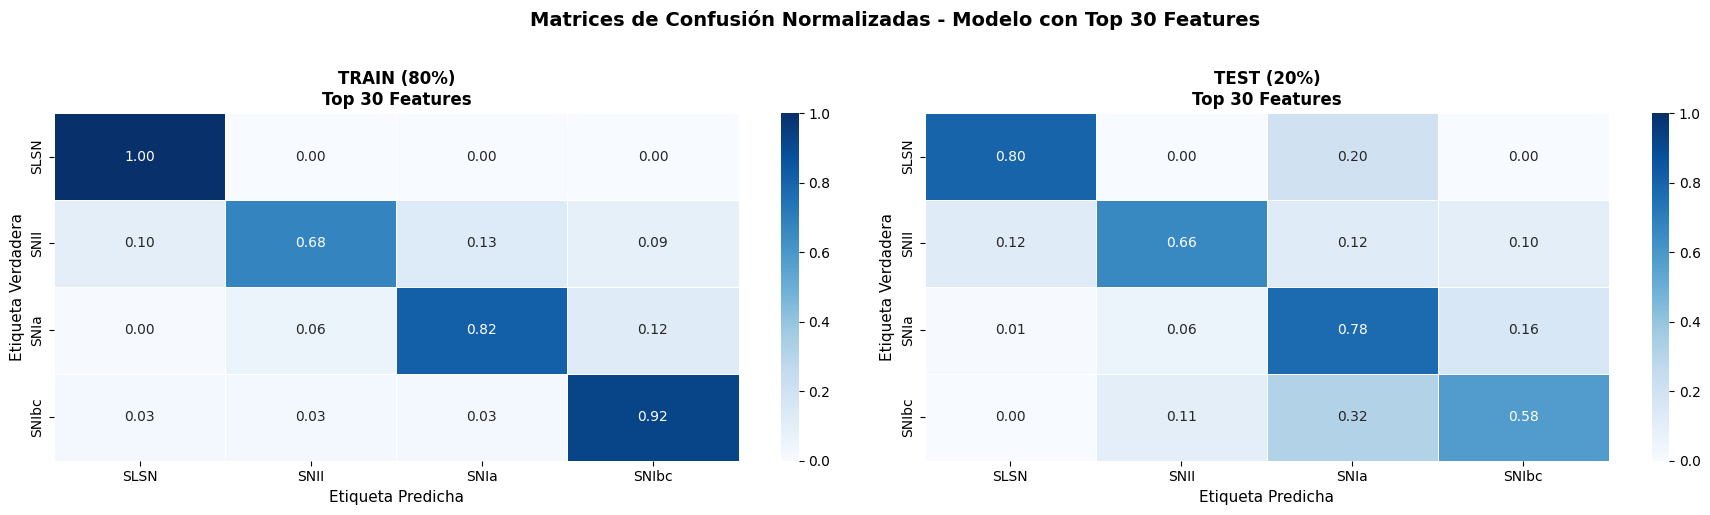

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix


# MATRICES (TRAIN / VALIDATION)


# Obtener predicciones
Y_pred_train = brf_reduced.predict(X_train)
Y_pred_test = brf_reduced.predict(X_test)

# Calcular matrices de confusión
cm_train = confusion_matrix(Y_train, Y_pred_train)
cm_test = confusion_matrix(Y_test, Y_pred_test)

# Normalizar matrices
cm_train_norm = cm_train.astype('float') / cm_train.sum(axis=1)[:, np.newaxis]
cm_test_norm = cm_test.astype('float') / cm_test.sum(axis=1)[:, np.newaxis]

# Obtener nombres de clases
class_names = sorted(Y_reduced.unique())

# Crear figura con tres subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# TRAIN (70%)
sns.heatmap(cm_train_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[0], cbar=True, vmin=0, vmax=1,
            linewidths=0.5, linecolor='white')
axes[0].set_title(f'TRAIN (80%)\nTop {N} Features',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Etiqueta Verdadera', fontsize=11)
axes[0].set_xlabel('Etiqueta Predicha', fontsize=11)


# TEST (15%)
sns.heatmap(cm_test_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            ax=axes[1], cbar=True, vmin=0, vmax=1,
            linewidths=0.5, linecolor='white')
axes[1].set_title(f'TEST (20%)\nTop {N} Features',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Etiqueta Verdadera', fontsize=11)
axes[1].set_xlabel('Etiqueta Predicha', fontsize=11)

plt.suptitle(f'Matrices de Confusión Normalizadas - Modelo con Top {N} Features',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

